We explore content-based filtering method. Songs are described with a set of lyrics and audio features, or the principal components generated during feature engineering. We assume users prefer to listen to songs that are similar to what they have listened to before. 

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import json
import ast
import os
import re

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler, StandardScaler
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# The following lines adjust the granularity of reporting
# pd.options.display.max_rows = 16
pd.set_option('display.max_columns', None)
# pd.options.display.float_format = "{:.1f}".format

# Importing Data

In [2]:
songs_feature_eng_pca = pd.read_csv(r'../Data/songs_feature_eng_pca.csv',
                                    na_filter=False  #because some track_name and artist_name are called 'null', other features do not have missing values based on previous inspection during dataset construction
)
songs_feature_eng_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129890 entries, 0 to 129889
Data columns (total 55 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   log_listeners        129890 non-null  float64
 1   log_total_playcount  129890 non-null  float64
 2   polarity             129890 non-null  float64
 3   subjectivity         129890 non-null  float64
 4   rms                  129890 non-null  float64
 5   spectral_centroid    129890 non-null  float64
 6   zcr                  129890 non-null  float64
 7   tempo                129890 non-null  float64
 8   mfcc_mean            129890 non-null  float64
 9   mfcc_var             129890 non-null  float64
 10  chroma_mean          129890 non-null  float64
 11  chroma_var           129890 non-null  float64
 12  profanity_low        129890 non-null  float64
 13  profanity_medium     129890 non-null  float64
 14  profanity_high       129890 non-null  float64
 15  duration_short   

In [ ]:
songs_all = pd.read_csv('unique_songs_features_complete.csv',
                        na_filter=False  #because some track_name and artist_name are called 'null', other features do not have missing values based on previous inspection during dataset construction
).drop('lyrics', axis=1)

def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return x
songs_all['toptags'] = songs_all['toptags'].apply(safe_eval)
songs_all.info()

# Converting song duration from milliseconds to minutes
songs_all['duration']=songs_all['duration_ms'].apply(lambda x : round((x/60000),2))
songs_all = songs_all.drop('duration_ms', axis=1)

In [ ]:
# feature engineering functions
def convert_to_float_list(s):
    # extract floating-point numbers
    # float_numbers = re.findall(r"[-+]?\d*\.\d+e[+-]?\d+|\d+", s)
    float_numbers = re.findall(r"[-+]?\d*\.\d+e[+-]?\d+|\d*\.\d+\s*|\d+\s*", s)
    # convert to list of floats
    float_list = [float(num) for num in float_numbers]
    return float_list

def calculate_mean_var(lst):
    if len(lst) > 0:
        audio_mean = np.mean(lst)
        audio_var = np.var(lst)
        return audio_mean, audio_var
    else:
        return np.nan, np.nan

def audio_feature_scaling(ls):
    if len(ls) > 0:
        return sklearn.preprocessing.scale(ls)
    else:
        return ls

def ohe_prep(df, column, new_name): 
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "_" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

def song_feature_eng(df, cols):
    df = df[cols]

    ## logarithmic transformation for values with large range
    df['log_total_playcount'] = np.log1p(df['total_playcount'])
    df['log_listeners'] = np.log1p(df['listeners'])
    
    ## transform audio features columns
    df['mfcc'] = df['mfcc'].apply(convert_to_float_list)
    df[['mfcc_mean', 'mfcc_var']] = pd.DataFrame(df['mfcc'].apply(calculate_mean_var).tolist(), index=df.index)
    df['mfcc_scaled'] = df['mfcc'].apply(audio_feature_scaling)
    df['mfcc_features'] = df['mfcc_scaled'].apply(lambda x: np.array(x).flatten())
    mfcc_features = np.stack(df['mfcc_features'])
    mfcc_features = pd.DataFrame(mfcc_features)
    mfcc_features.columns = [f'mfcc_{i+1}' for i in range(mfcc_features.shape[1])]
    
    df['chroma'] = df['chroma'].apply(convert_to_float_list)
    df[['chroma_mean', 'chroma_var']] = pd.DataFrame(df['chroma'].apply(calculate_mean_var).tolist(), index=df.index)

    ## normalize features
    normalize_features = ['log_listeners', 'log_total_playcount', 'polarity', 'subjectivity', 'rms',  'spectral_centroid', 'zcr', 'tempo', 
                          'chroma_mean', 'chroma_var',
                          'mfcc_mean', 'mfcc_var'
                          ]
    songs_all_normalize = df[normalize_features].reset_index(drop = True)
    # Robust Scaler algorithms scale features that are robust to outliers. The method it follows is almost similar to the MinMax Scaler but it uses 
    # the interquartile range (rather than the min-max used in MinMax Scaler). The median and scales of the data are removed by this scaling algorithm according to the quantile range.
    scaler = RobustScaler(quantile_range = (20,80))
    # scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(songs_all_normalize), columns = songs_all_normalize.columns) 

    ## one-hot encoding features
    df['duration_bin'] = pd.qcut(df['duration'], q=3, labels=['short', 'medium', 'long'])
    df['profanity_density_bin'] = pd.qcut(df['profanity_density'].rank(method='first'), q=3, labels=['low', 'medium', 'high'])

    profanity_ohe = ohe_prep(df, 'profanity_density_bin', 'profanity') *0.3
    duration_ohe = ohe_prep(df, 'duration_bin', 'duration')*0.3
    emotion_ohe = ohe_prep(df, 'emotion1', 'emotion') 

    ## concat to create final df
    eng_df = pd.concat([floats_scaled, profanity_ohe, duration_ohe, emotion_ohe, mfcc_features, 
                        ], axis = 1)
    eng_df['track_name'] = df['track_name_original'].values
    eng_df['artist_name'] = df['artist_name_original'].values
    
    return eng_df

# KMeans Clustering

## Using PCA results

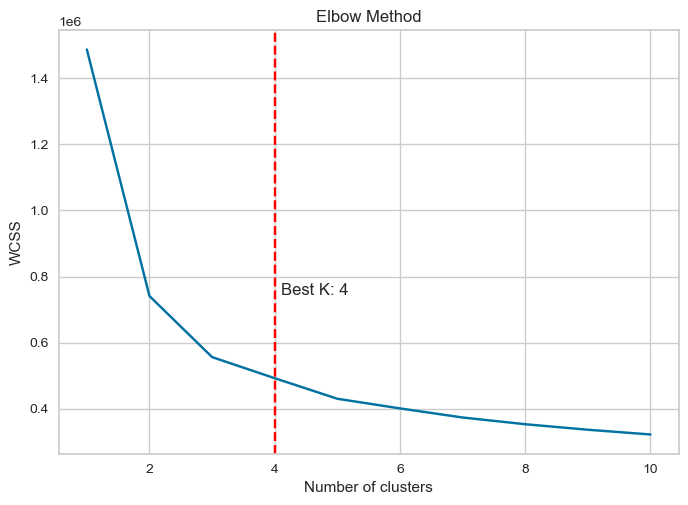

In [3]:
# Using PCA results
X_pca = songs_feature_eng_pca[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']]
# Within-Cluster-Sum-of-Squares
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
# plot the elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# show the best k value
best_k = 4
plt.axvline(x=best_k, linestyle='--', color='red')
plt.text(best_k + 0.1, max(wcss)/2, f'Best K: {best_k}')
plt.show()

C:\Users\Xzyu\AppData\Local\Temp\ipykernel_1452\1519128131.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pca['cluster'] = kmeans.fit_predict(X_pca)


[[ 4.78947661  1.97714683  0.03010567 -0.01626755  0.10112003  0.54858824]
 [-0.70885916 -1.11039913  0.13373088  0.28708156 -0.01166027  0.27024422]
 [-2.33337803  1.05579969 -0.09944751 -0.22171256  0.01400937 -0.15447467]
 [ 3.54232514 -0.34086965 -0.14462599 -0.25470731 -0.04931468 -0.62274319]]
[2 1 1 ... 1 1 1]


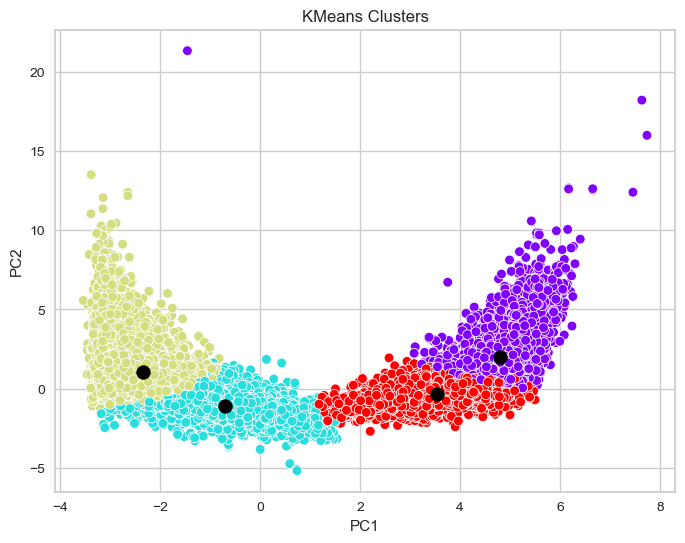

In [62]:
# Applying KMeans clustering with the chosen number of clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters = optimal_clusters, n_init=10, random_state=42)
X_pca['cluster'] = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_[:, :6]
print(centroids)

# # calculate silhouette score
# silhouette = silhouette_score(X_pca, X_pca['cluster'])
# print(f"Silhouette Score for {optimal_clusters} clusters: {silhouette}")

kmeans_labels = kmeans.labels_
print(kmeans_labels)
# Visualization of KMeans clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x = X_pca['PC1'], y = X_pca['PC2'], c=kmeans_labels, cmap='rainbow')
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', label='centroid')
plt.title('KMeans Clusters')
plt.show()

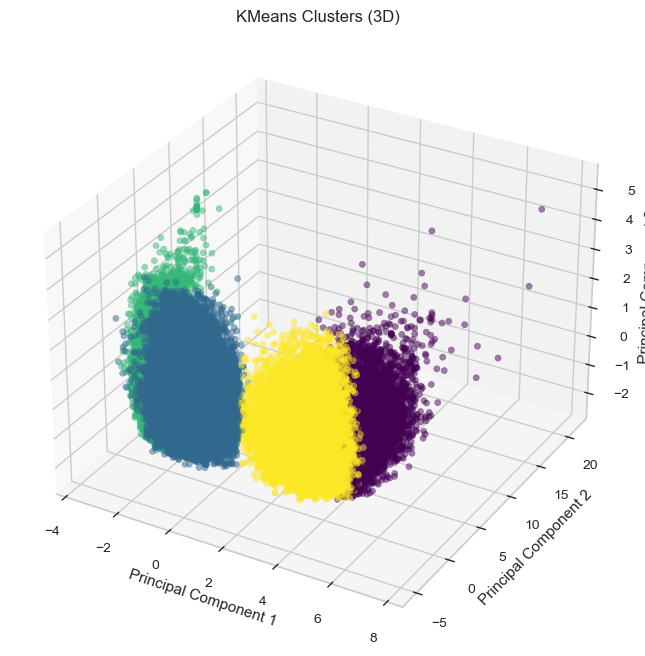

In [6]:
# 3D Scatter plot visualization for the first three principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca['PC1'], X_pca['PC2'], X_pca['PC3'], c=X_pca['cluster'], cmap='viridis', alpha=0.5)
ax.set_title('KMeans Clusters (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

In [64]:
track_name = 'Cradle'
artist_name = 'Mudvayne'
df = songs_feature_eng_pca[(songs_feature_eng_pca['track_name']==track_name) & (songs_feature_eng_pca['artist_name']==artist_name)]
input_row = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']].iloc[0].values.reshape(1, -1)

# Compute cosine similarity between the input row and each cluster centroid
similarities = cosine_similarity(input_row, centroids)
cluster_labels = X_pca['cluster']

# Get the top 10 songs with the highest cosine similarity to the input row based on the similarity
indices = np.argsort(similarities)[0][::-1][:1]
recommended_songs_index = [i for i in range(len(cluster_labels)) if cluster_labels[i] in indices]

# songs_feature_eng_pca.iloc[recommended_songs_index].head(10)
recommended_songs = songs_feature_eng_pca.iloc[recommended_songs_index]
recommended_songs['similarity'] = [cosine_similarity(input_row, song[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']].values.reshape(1, -1))[0][0] for _, song in recommended_songs.iterrows()]
recommended_songs['cluster'] = cluster_labels.iloc[recommended_songs_index].values
recommended_songs = recommended_songs.sort_values(by='similarity', ascending=False).head(11)
recommended_songs[['track_name', 'artist_name', 'similarity', 'cluster']]

C:\Users\Xzyu\AppData\Local\Temp\ipykernel_1452\1690707760.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_songs['similarity'] = [cosine_similarity(input_row, song[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']].values.reshape(1, -1))[0][0] for _, song in recommended_songs.iterrows()]
C:\Users\Xzyu\AppData\Local\Temp\ipykernel_1452\1690707760.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_songs['cluster'] = cluster_labels.iloc[recommended_songs_index].values


,track_name,artist_name,similarity,cluster
0,Cradle,Mudvayne,1.000000,2
89194,Neon Memories,death's dynamic shroud,0.995416,2
13469,Face 2 Face,Juice WRLD,0.994576,2
95965,Prayer to God,Shellac,0.993058,2
24194,Knock You Out,Bingo Players,0.992198,2
4981,Testimony,Kodak Black,0.991265,2
67804,"You Don't Remember, I'll Never Forget",Yngwie Malmsteen,0.990283,2
24628,Letters to God,Box Car Racer,0.988458,2
112303,"Misty Morning, Albert Bridge",The Pogues,0.988269,2
35548,going out,Role Model,0.987563,2


In [ ]:
# TODO write into a function
def recommend_kmeans(df, track_name, artist_name):
    
    pass

## Using Song Features

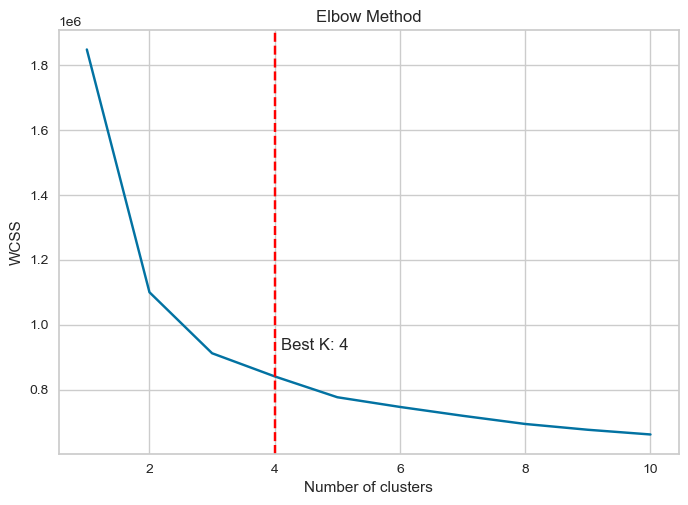

In [51]:
# X with feature engineering
eng_features = ['log_listeners', 'log_total_playcount', 'polarity', 'subjectivity',
       'rms', 'spectral_centroid', 'zcr', 'tempo', 'mfcc_mean', 'mfcc_var',
       'chroma_mean', 'chroma_var', 'profanity_low', 'profanity_medium',
       'profanity_high', 'duration_short', 'duration_medium', 'duration_long',
       'emotion_anger', 'emotion_disgust', 'emotion_fear', 'emotion_joy',
       'emotion_negative', 'emotion_positive', 'emotion_sadness',
       'emotion_surprise', 'emotion_trust', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16',
       'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20']
X_eng = songs_feature_eng_pca[eng_features]
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
    kmeans.fit(X_eng)
    wcss.append(kmeans.inertia_)

# plot the elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# show the best k value
best_k = 4
plt.axvline(x=best_k, linestyle='--', color='red')
plt.text(best_k + 0.1, max(wcss)/2, f'Best K: {best_k}')

plt.show()

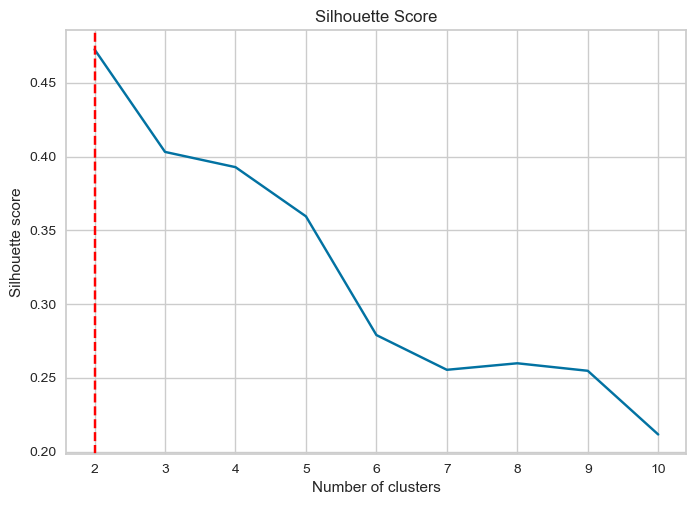

In [52]:
# # calculate Silhouette score for different number of clusters
# silhouette_scores = []
# for i in range(2, 11):
#     kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#     kmeans.fit(X_pca)
#     labels = kmeans.labels_
#     silhouette_scores.append(silhouette_score(X_pca, labels))

# # plot the Silhouette score
# plt.plot(range(2, 11), silhouette_scores)
# plt.title('Silhouette Score')
# plt.xlabel('Number of clusters')
# plt.ylabel('Silhouette score')

# # show the best k value
# best_k = silhouette_scores.index(max(silhouette_scores)) + 2
# plt.axvline(x=best_k, linestyle='--', color='red')

# plt.show()

In [60]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
kmeans.fit(X_eng)
cluster_labels = kmeans.predict(X_eng)
centroids = kmeans.cluster_centers_
# print(centroids)
kmeans_labels = kmeans.labels_
np.unique(kmeans_labels, return_counts=True)

(array([0, 1, 2, 3]), array([43568, 12494, 51939, 21889], dtype=int64))